# Gaussian mixture demo using PyMC3

What is new?

https://pymc-devs.github.io/pymc3/notebooks/gaussian_mixture_model.html

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
sns.set_context('paper')
sns.set_style('darkgrid')

import pymc3 as pm, theano.tensor as tt


Wed Nov 16 08:42:53 CST 2016


/Users/kersten/anaconda/envs/pymc3/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


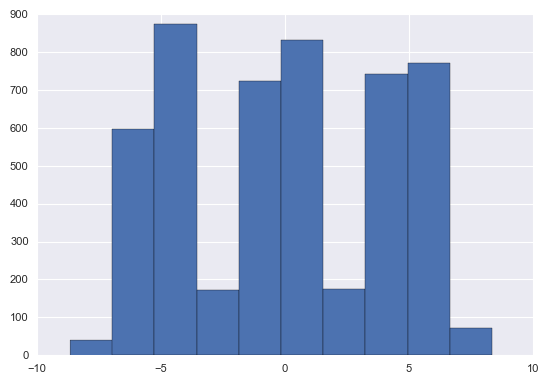

In [3]:
np.random.seed(12345) # set random seed for reproducibility

k = 3
ndata = 5000
spread = 5
centers = np.array([-spread, 0, spread])

# simulate data from mixture distribution
v = np.random.randint(0, 3, ndata)
data = centers[v] + np.random.randn(ndata)

plt.hist(data);

In [4]:
# setup model
model = pm.Model()
with model:
    # cluster sizes
    p = pm.Dirichlet('p', a=np.array([1., 1., 1.]), shape=k)
    # ensure all clusters have some points
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))


    # cluster centers
    means = pm.Normal('means', mu=[0, 0, 0], sd=15, shape=k)
    # break symmetry
    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0)
                                         + tt.switch(means[2]-means[1] < 0, -np.inf, 0))

    # measurement error
    sd = pm.Uniform('sd', lower=0, upper=20)

    # latent cluster of each observation
    category = pm.Categorical('category',
                              p=p,
                              shape=ndata)

    # likelihood for each observed value
    points = pm.Normal('obs',
                       mu=means[category],
                       sd=sd,
                       observed=data)

Applied stickbreaking-transform to p and added transformed p_stickbreaking_ to model.
Applied interval-transform to sd and added transformed sd_interval_ to model.


In [6]:

# fit model
with model:
    step1 = pm.Metropolis(vars=[p, sd, means])
    step2 = pm.ElemwiseCategorical(vars=[category], values=[0, 1, 2])
    tr = pm.sample(1000, step=[step1, step2])

100%|██████████| 1000/1000 [01:25<00:00, 11.26it/s]


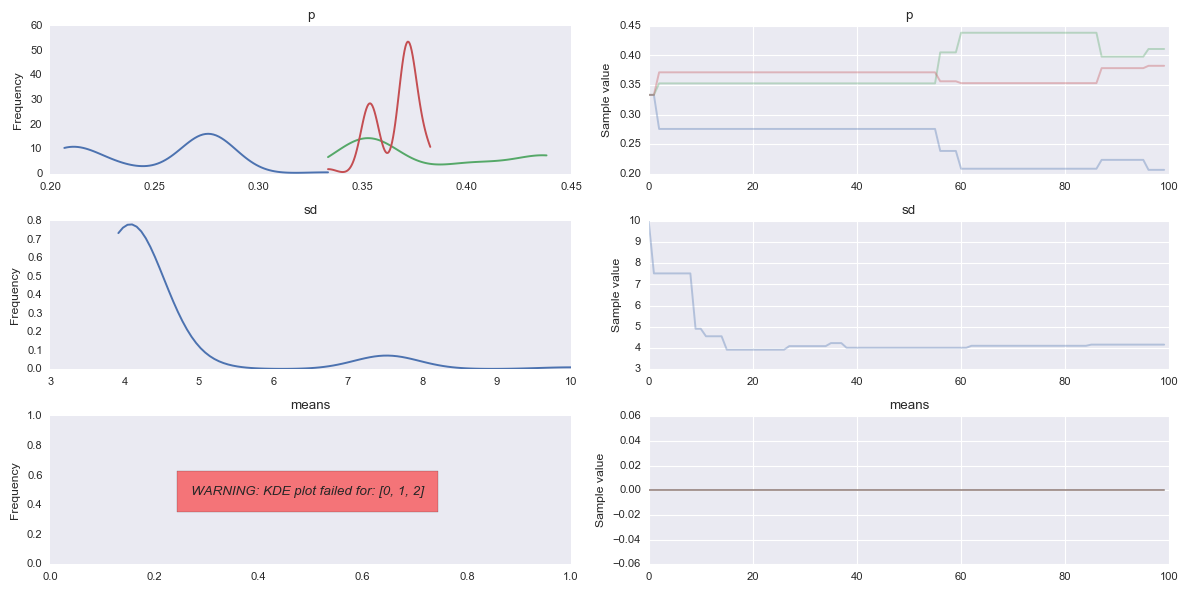

In [7]:
pm.plots.traceplot(tr, ['p', 'sd', 'means']);

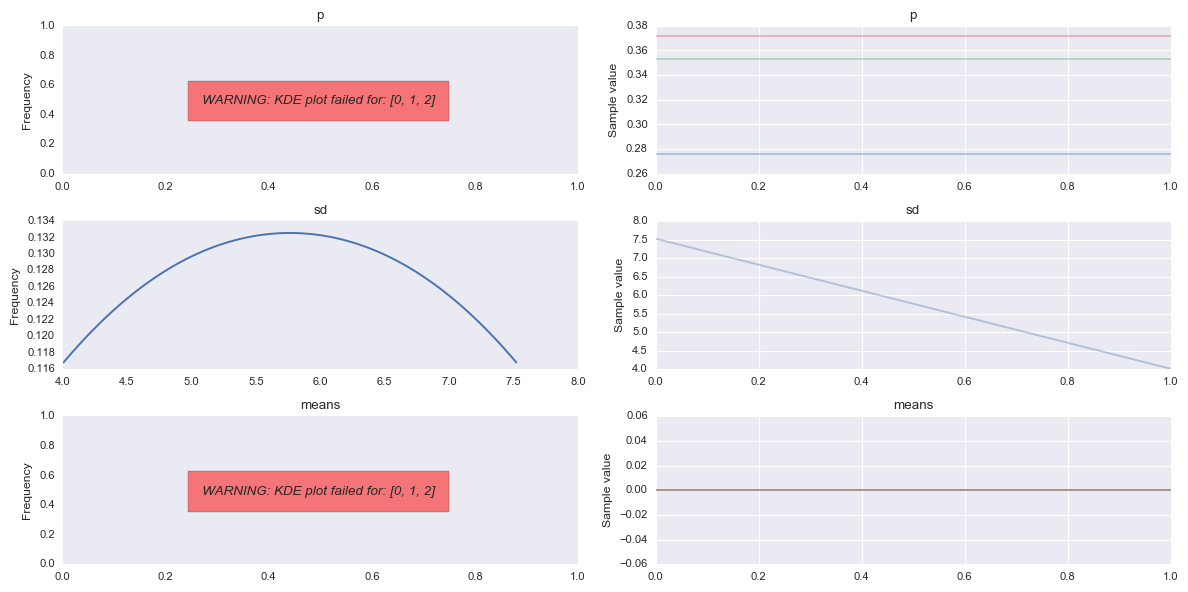

In [9]:
# take a look at traceplot for some model parameters
# (with some burn-in and thinning)
pm.plots.traceplot(tr[5::50], ['p', 'sd', 'means']);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117696690>]], dtype=object)

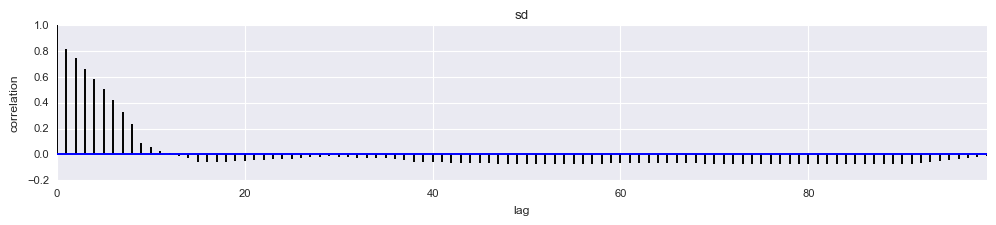

In [12]:

# Autocorrelation plots to examine for MCMC convergence
pm.autocorrplot(tr, varnames=['sd'])

In [ ]:
pm.autocorrplot(tr[], varnames=['sd'])